# Implementation of AutoEncoder (AE) (New latent vec for customers)


## AE

- no assumption at latent vec distribution
- bias on latent vec rather than generative ability

python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler

'''
A clustering result satisfies completeness,
if all the data points that are members of a given class are elements of the same cluster.
'''
from sklearn.metrics.cluster import completeness_score

import pandas as pd

import matplotlib.cm as cm
from matplotlib import pyplot as plt

In [2]:
# Model Hyperparameters

dataset_path = './'

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [3]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_proportion = 0.8
# partition dataset according to train_proportion
train_indices, val_indices = partition_dataset(len(train_dataset), train_proportion)
# create data loaders for train, validation and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

9913344it [00:00, 10861011.18it/s]                             


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



29696it [00:00, 29719411.02it/s]         


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



1649664it [00:00, 6516738.12it/s]                             


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



5120it [00:00, 2576774.24it/s]          

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw




C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# AE

# For Paul

1. You need to import mnist dataset using the code from 01_Variational_AutoEncoder.ipynb

2. Also, I commented out VAE part, this is only AE

# Model Hyperparameters

###    Step 1. Load (or download) Dataset

### Step 2. Define our model: AutoEncoder (AE)

In [11]:
"""
    A simple implementation of MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        return mean, log_var                   

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [13]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

In [14]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [15]:
print(model)

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=784, out_features=400, bias=True)
    (FC_input2): Linear(in_features=400, out_features=400, bias=True)
    (FC_mean): Linear(in_features=400, out_features=200, bias=True)
    (FC_var): Linear(in_features=400, out_features=200, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=200, out_features=400, bias=True)
    (FC_hidden2): Linear(in_features=400, out_features=400, bias=True)
    (FC_output): Linear(in_features=400, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)


### Step 3. Define Loss function (reprod. loss) and optimizer

In [16]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

### Step 4. Train & val  

In [17]:
print("Start training VAE...")
model.train()

training_losses = []
val_losses = []
lrs = []

for epoch in range(epochs):
    training_loss = 0
    val_loss = 0

    # training
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        training_loss += loss.item()       

        loss.backward()
        optimizer.step()

    average_training_loss = training_loss/len(train_dataset)
    training_losses.append(average_training_loss)

    # validation
    for batch_idx, (x, _) in enumerate(val_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        val_loss += loss.item()

    average_val_loss = val_loss/len(test_dataset)
    val_losses.append(average_val_loss)

    scheduler.step(val_loss)    
    lrs.append(scheduler._last_lr[0])

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Train Loss: ", average_training_loss, "\tAverage Val Loss: ", average_val_loss)

    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Train Loss:  145.47634174804688 	Average Val Loss:  181.51059365234374
	Epoch 2 complete! 	Average Train Loss:  108.80005919596354 	Average Val Loss:  151.21636044921874
	Epoch 3 complete! 	Average Train Loss:  97.27614099934895 	Average Val Loss:  143.12210009765624
	Epoch 4 complete! 	Average Train Loss:  92.87811235351562 	Average Val Loss:  137.21301416015626
	Epoch 5 complete! 	Average Train Loss:  89.98974189453125 	Average Val Loss:  133.82853955078124
	Epoch 6 complete! 	Average Train Loss:  88.06522513020833 	Average Val Loss:  131.79170615234375
	Epoch 7 complete! 	Average Train Loss:  86.78823901367187 	Average Val Loss:  130.08035234375
	Epoch 8 complete! 	Average Train Loss:  85.97542501627605 	Average Val Loss:  129.0344197265625
	Epoch 9 complete! 	Average Train Loss:  85.28487884114584 	Average Val Loss:  128.1753189453125
	Epoch 10 complete! 	Average Train Loss:  84.65247690429688 	Average Val Loss:  127.69391005859374


### Plot loss over epoch - Latent_dim=2

Text(0, 0.5, 'Loss')

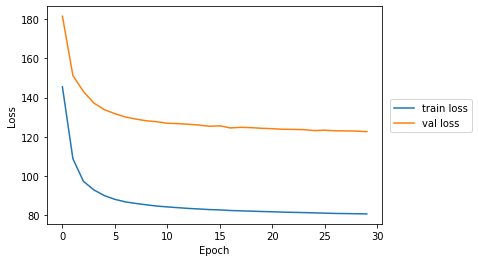

In [18]:
ax, fig = plt.subplots()
plt.plot(training_losses)
plt.plot(val_losses)
ax.legend(['train loss', 'val loss'], bbox_to_anchor=(1.12,0.5), loc="center right",)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'LR')

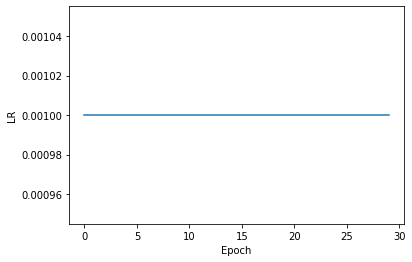

In [19]:
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('LR')

## Step 5. Generate images from test dataset

In [21]:
import matplotlib.pyplot as plt
model.eval()

# Test with only the first batch
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)
        break

100%|██████████| 100/100 [00:02<00:00, 43.05it/s]


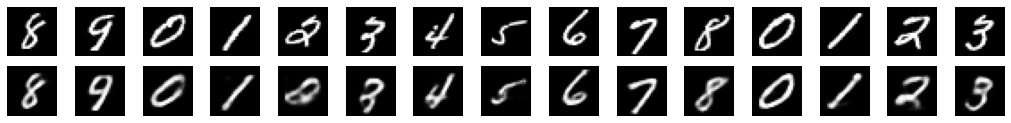

In [32]:
# Compare reconstructed images with original images
def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

display_reconstructed(x[0:15], x_hat[0:15], 15)

## Step 6. Plot latent features with true labels

In [34]:
# Get features and true labels
model.eval()
start_ind = 0
n = len(test_loader.dataset)
true_labels = np.zeros(n, dtype=np.int64)
features = np.zeros((n, latent_dim))
with torch.no_grad():
    for (x, y) in test_loader:
        # flatten data
        x = x.view(x.size(0), -1)  
        x_hat, mean, log_var = model(x)
        end_ind = min(start_ind + x.size(0), n+1)

        true_labels[start_ind:end_ind] = y
        features[start_ind:end_ind] = mean
        start_ind += x.size(0)

In [35]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE is a slow algorithm
tsne_features = TSNE(n_components=2).fit_transform(features[:1000,])

C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'VAE')

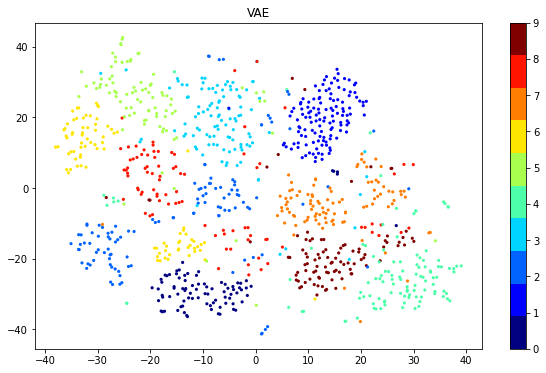

In [44]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=true_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.colorbar()
plt.title('VAE')

## VAE + Kmeans

Text(0.5, 1.0, 'VAE + KMeans')

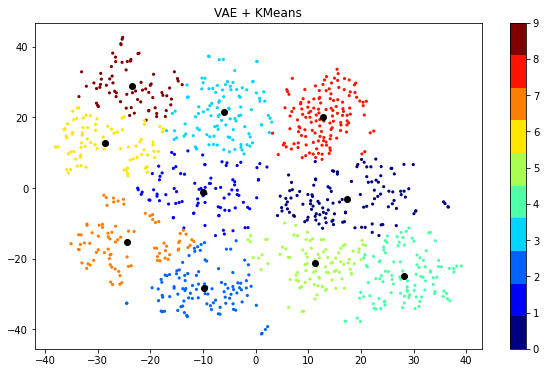

In [75]:
kmeans = KMeans(n_clusters=10).fit(tsne_features)
y_kmeans = kmeans.predict(tsne_features)

fig = plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_kmeans, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.colorbar()
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black')
plt.title('VAE + KMeans')

## VAE + GMM

Text(0.5, 1.0, 'VAE + GMM')

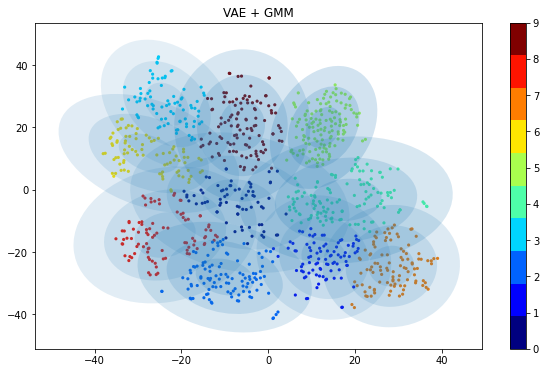

In [81]:
from sklearn import mixture
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

gmm = mixture.GaussianMixture(n_components=10).fit(tsne_features)
y_gmm = gmm.predict(tsne_features)

fig = plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_gmm, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.colorbar()
w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)
plt.title('VAE + GMM')

## VAE + DPGMM

C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Text(0.5, 1.0, 'VAE + DPGMM')

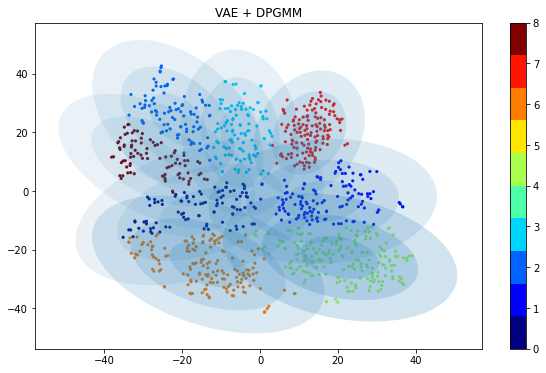

In [86]:
from sklearn import mixture
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

dpgmm = mixture.BayesianGaussianMixture(n_components=10).fit(tsne_features)
y_dpgmm = dpgmm.predict(tsne_features)

fig = plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_dpgmm, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.colorbar()
w_factor = 0.2 / dpgmm.weights_.max()
for pos, covar, w in zip(dpgmm.means_, dpgmm.covariances_, dpgmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)
plt.title('VAE + DPGMM')